# Gruppenprojekt ML-Sensordaten

In [3]:
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier


**Erster Schritt, Daten einlesen und sich einen Überblick über Spalten und Zeilen verschaffen**

In [84]:
df_sensor_raw = pd.read_csv('../data/Datensatz-Sensor.csv')
print(f"{df_sensor_raw.head()}\n------\n{df_sensor_raw.describe()}\n------\n{df_sensor_raw.shape}")

                 Datum  Temperatur  Feuchtigkeit         CO2  Wassergehalt  \
0  2015-02-02 14:19:00     23.7000        26.272  749.200000      0.004764   
1  2015-02-02 14:19:59     23.7180        26.290  760.400000      0.004773   
2  2015-02-02 14:21:00     23.7300        26.230  769.666667      0.004765   
3  2015-02-02 14:22:00     23.7225        26.125  774.750000      0.004744   
4  2015-02-02 14:23:00     23.7540        26.200  779.000000      0.004767   

   Anwesenheit  
0            1  
1            1  
2            1  
3            1  
4            1  
------
         Temperatur  Feuchtigkeit           CO2  Wassergehalt   Anwesenheit
count  19134.000000  18915.000000  19236.000000  18777.000000  19236.000000
mean      21.322743     27.451396    634.818354      0.004189      0.226606
std        3.908221      5.008853    260.246196      0.000759      0.418647
min       19.000000     16.745000      0.000000      0.002674      0.000000
25%       20.133333     24.290000    454.5

In [86]:
df_sensor_raw.isna().sum().sort_values(ascending=False)

Wassergehalt    459
Feuchtigkeit    321
Temperatur      102
Datum             0
CO2               0
Anwesenheit       0
dtype: int64

Visualisieren Feature nach Feature

### Wassergehalt

<function matplotlib.pyplot.show(close=None, block=None)>

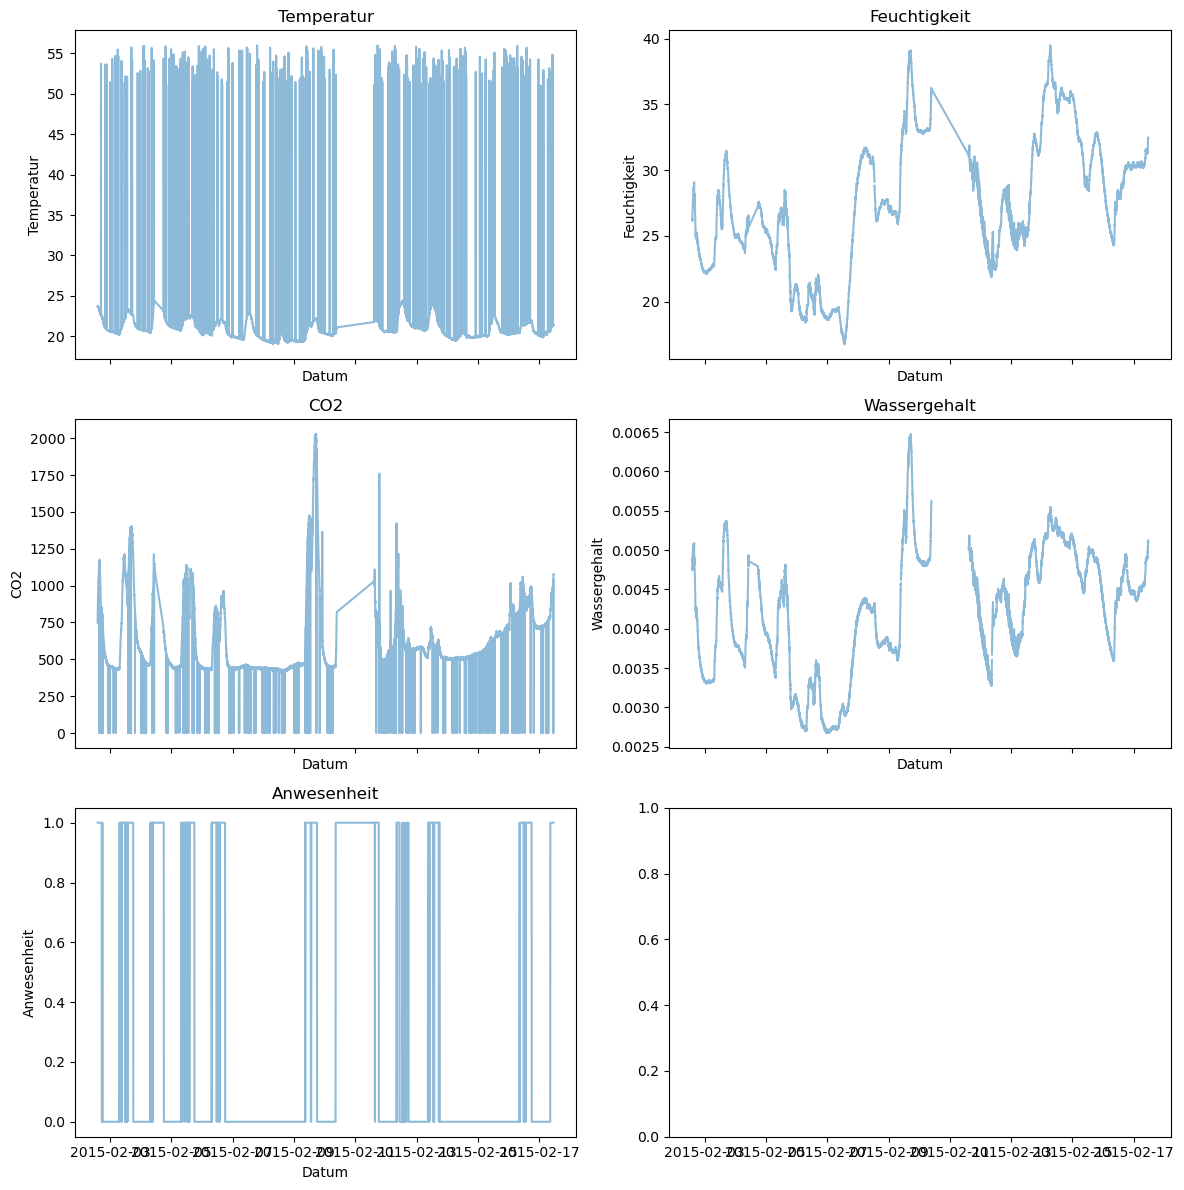

In [47]:
import numpy as np
import math 

# Alle numerischen Spalten außer Datum
num_cols = df_sensor_raw.select_dtypes(include="number").columns.tolist()

date_col = "Datum"
df_sensor_raw['Datum'] = pd.to_datetime(df_sensor_raw['Datum'])
df_sensor_raw = df_sensor_raw.sort_values(date_col)

# Grid für Subplots berechnen
n_cols = 2 # Plots bro Zeile
n_rows = math.ceil(len(num_cols) / n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows), sharex=True)

# axes in 1D-Array umwandeln
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, num_cols):
    ax.plot(df_sensor_raw['Datum'], df_sensor_raw[col], alpha=0.5)
    ax.set_title(col)
    ax.set_xlabel('Datum')
    ax.set_ylabel(col)


for ax in axes[len(num_col):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show

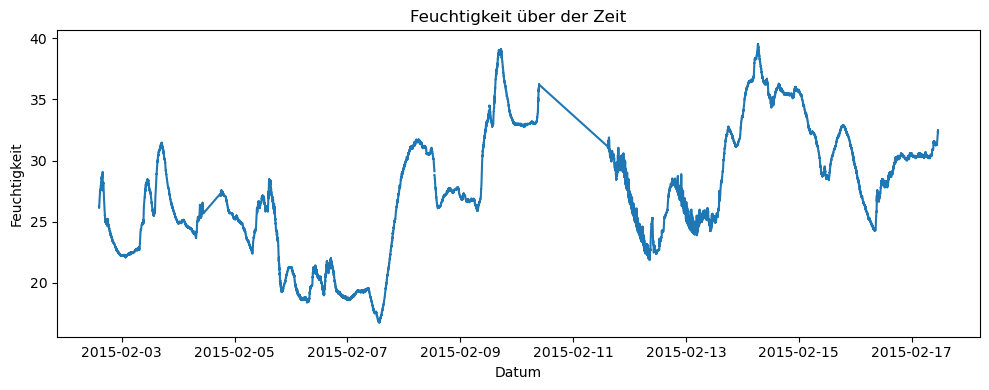

In [ ]:
# Plot für Feuchtigkeit

plt.figure(figsize=(10,4))
plt.plot(df_sensor_raw['Datum'], df_sensor_raw['Feuchtigkeit'])
plt.title('Feuchtigkeit über der Zeit')
plt.xlabel('Datum')
plt.ylabel('Feuchtigkeit')
plt.tight_layout()
plt.show()

In [60]:
wassergehalt_clean = df_sensor_raw['Wassergehalt'].dropna()

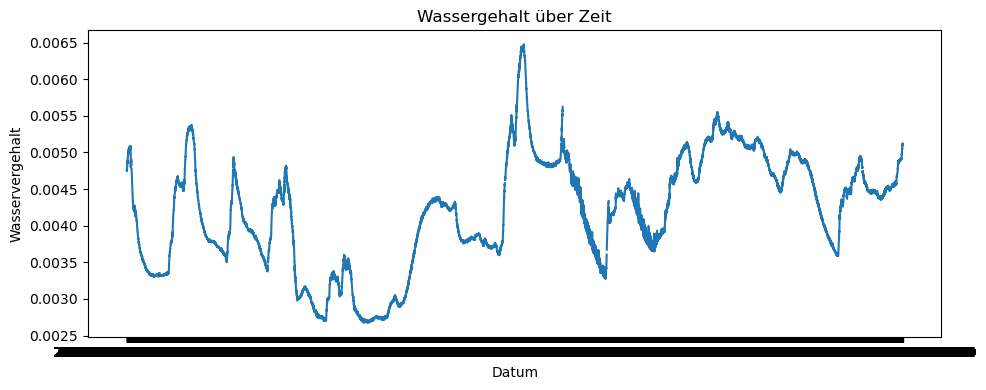

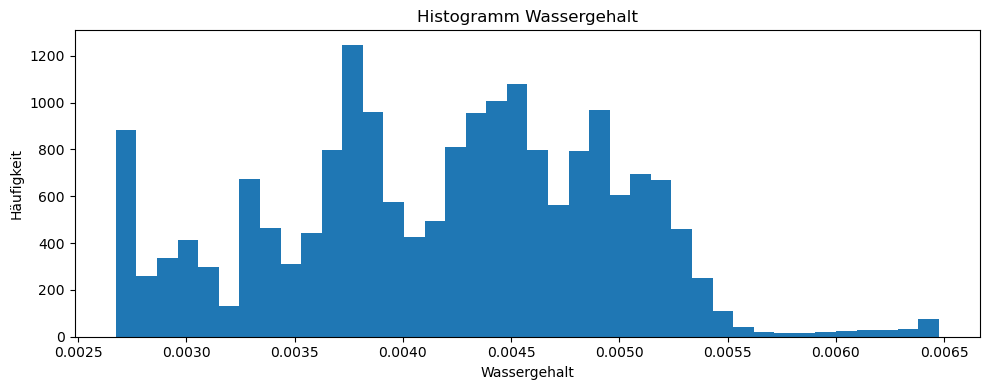

In [87]:
# Zeitreihenplot

plt.figure(figsize=(10,4))
plt.plot(df_sensor_raw['Datum'], df_sensor_raw['Wassergehalt'].fillna(wassergehalt_clean))
plt.title('Wassergehalt über Zeit')
plt.xlabel('Datum')
plt.ylabel('Wasservergehalt')
plt.tight_layout()
plt.show()

# Histogramm
plt.figure(figsize=(10,4))
plt.hist(df_sensor_raw['Wassergehalt'], bins=40)
plt.title('Histogramm Wassergehalt')
plt.xlabel('Wassergehalt')
plt.ylabel('Häufigkeit')
plt.tight_layout()
plt.show()

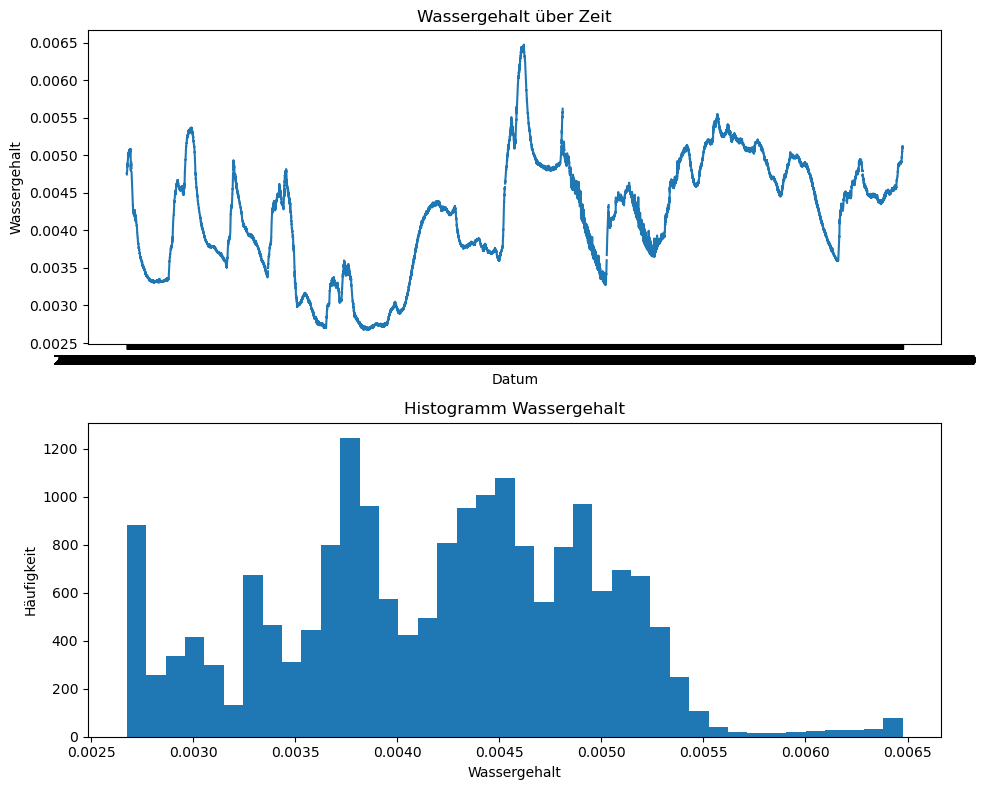

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(10,8))

# Zeitreihe
axs[0].plot(df_sensor_raw['Datum'], df_sensor_raw['Wassergehalt'])
axs[0].set_title('Wassergehalt über Zeit')
axs[0].set_xlabel('Datum')
axs[0].set_ylabel('Wassergehalt')

# Histogramm
axs[1].hist(df_sensor_raw['Wassergehalt'], bins=40)
axs[1].set_title('Histogramm Wassergehalt')
axs[1].set_xlabel('Wassergehalt')
axs[1].set_ylabel('Häufigkeit')

plt.tight_layout()
plt.show()


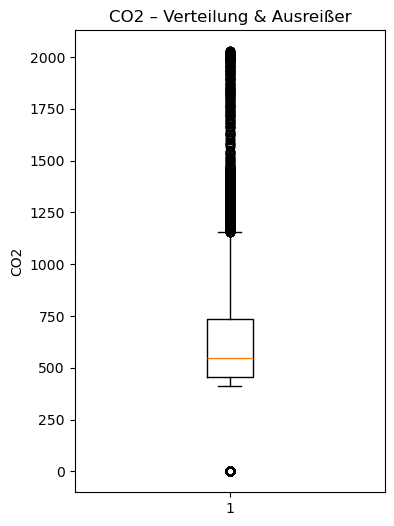

In [72]:
# Temperatur

plt.figure(figsize=(4,6))
plt.boxplot(df_sensor_raw['CO2'].dropna(), vert=True)
plt.title('CO2 – Verteilung & Ausreißer')
plt.ylabel('CO2')
plt.show()

<Axes: >

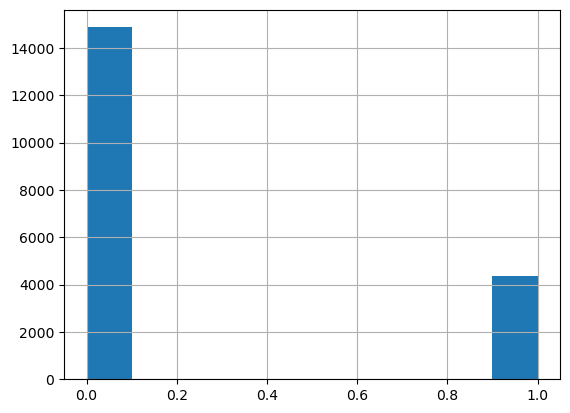

In [89]:
df_sensor_raw['Anwesenheit'].hist()